In [ ]:
!pip install foolbox

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 62 kB 822 kB/s 
     |████████████████████████████████| 180 kB 40.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import torch
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import FGSM
from foolbox.criteria import Misclassification
from fastai import *
from fastai.vision import *
import foolbox as fb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
loc = torch.load('/content/drive/MyDrive/FYP/resnet34_new.pth')
body = create_body(models.resnet34, True, None)
data_classes = 2
nf = callbacks.hooks.num_features_model(body) * 2
head = create_head(nf, data_classes, None, ps=0.5, bn_final=False)
model = nn.Sequential(body, head)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
model.load_state_dict(loc['model'])
model = model.eval()

In [ ]:
fmodel = PyTorchModel(model, bounds=(0, 1))

In [ ]:
import cv2
import os
from PIL import Image
from typing import Optional, Tuple, Any
import eagerpy as ep
import warnings
import numpy as np

def load_images_from_folder(fmodel, folder):
    images = []
    labels = []
    # i = 0
    for filename in os.listdir(folder):
      # if i > 15:
      #   break
      # img = cv2.imread(os.path.join(folder,filename))
      img = Image.open(os.path.join(folder,filename))
      if img is not None:
        img = np.asarray(img, dtype=np.float32)
        img = np.transpose(img, (2, 0, 1))
        img = img/255

        if img.ndim == 2:
            img = img[..., np.newaxis]

        assert img.ndim == 3

        images.append(img)
        labels.append(int(str(folder)))

      # i += 1

    images = np.stack(images)
    labels = np.array(labels)

    if hasattr(fmodel, "dummy") and fmodel.dummy is not None:  # type: ignore
        images = ep.from_numpy(fmodel.dummy, images).raw  # type: ignore
        labels = ep.from_numpy(fmodel.dummy, labels).raw  # type: ignore
    else:
        warnings.warn(f"unknown model type {type(fmodel)}, returning NumPy arrays")

    return images, labels

In [ ]:
cd '/content/drive/MyDrive/FYP_Dataset_unresized'

/content/drive/MyDrive/FYP_Dataset_unresized


In [ ]:
from PIL import Image
import os, sys

path = "/content/drive/MyDrive/FYP_Dataset_unresized/1"

def resize():
    for i in os.listdir(path):
      file = f"{path}/{i}"
      im = Image.open(file)
      im = im.resize((256, 256), Image.ANTIALIAS)
      im.save(file)

In [ ]:
resize()

In [ ]:
images, labels = load_images_from_folder(fmodel, '1')

In [ ]:
type(images), images.shape

(torch.Tensor, torch.Size([880, 3, 256, 256]))

In [ ]:
type(labels), labels.shape

(torch.Tensor, torch.Size([880]))

In [ ]:
clean_acc = fb.utils.accuracy(fmodel, images, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

RuntimeError: ignored

In [ ]:
attack = fb.attacks.PGD()

epsilons = [
        # 0.0,
        # 0.0002,
        # 0.0005,
        # 0.0008,
        # 0.001,
        # 0.0015,
        # 0.002,
        # 0.003,
        # 0.01,
        # 0.05,
        0.1,
        # 0.2,
        # 0.3,
        # 0.5,
        # 1.0,
    ]
raw_advs_array4 = []
clipped_advs_array4 = []
success_array4 = []
idx = 660
while idx < 880:
  criterion = Misclassification(labels[idx:idx+1])
  raw_advs, clipped_advs, success = attack(fmodel, images[idx:idx+1], criterion, epsilons=0.07)
  raw_advs_array4.append(raw_advs)
  clipped_advs_array4.append(clipped_advs)
  success_array4.append(success)
  idx += 1
  print(len(clipped_advs_array4))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220


In [ ]:
clipped_advs_array1[0].shape

torch.Size([1, 3, 256, 256])

In [ ]:
len(clipped_advs_array1)

220

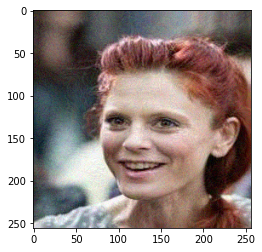

In [ ]:
plt.imshow(clipped_advs_array1[0][0].cpu().permute(1, 2, 0)  )

In [ ]:
from torchvision.utils import save_image
i = 660
for batch in clipped_advs_array4:
  for image in batch:
    save_image(image, '/content/results/1/img' + str(i) + '.png')
    i += 1

In [ ]:
print(i)

880


In [ ]:
!zip -r "/content/results_1.zip" "/content/results/1"
from google.colab import files
files.download("/content/results_1.zip")

  adding: content/results/1/ (stored 0%)
  adding: content/results/1/img19.png (deflated 0%)
  adding: content/results/1/img852.png (deflated 0%)
  adding: content/results/1/img346.png (deflated 0%)
  adding: content/results/1/img496.png (deflated 0%)
  adding: content/results/1/img766.png (deflated 0%)
  adding: content/results/1/img615.png (deflated 0%)
  adding: content/results/1/img264.png (deflated 0%)
  adding: content/results/1/img631.png (deflated 0%)
  adding: content/results/1/img847.png (deflated 0%)
  adding: content/results/1/img757.png (deflated 0%)
  adding: content/results/1/img177.png (deflated 0%)
  adding: content/results/1/img370.png (deflated 0%)
  adding: content/results/1/img254.png (deflated 0%)
  adding: content/results/1/img537.png (deflated 0%)
  adding: content/results/1/img712.png (deflated 0%)
  adding: content/results/1/img702.png (deflated 0%)
  adding: content/results/1/img75.png (deflated 0%)
  adding: content/results/1/img121.png (deflated 0%)
  addin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

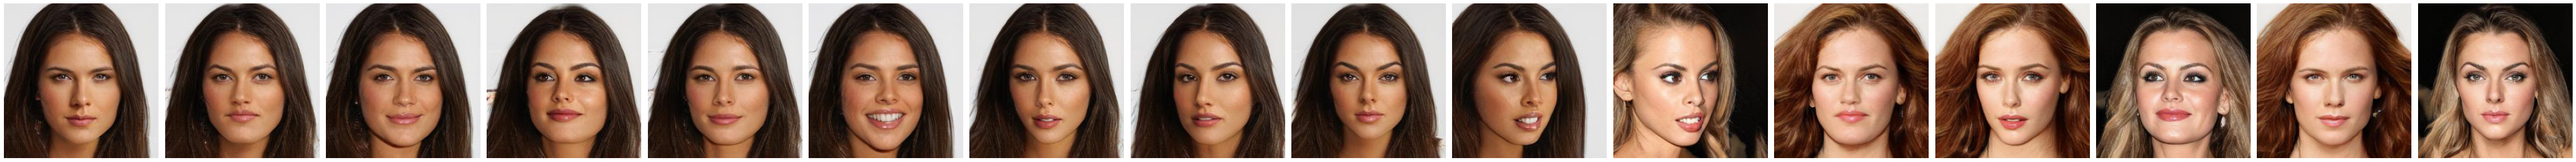

In [ ]:
fb.plot.images(images[0:16], scale=4.)

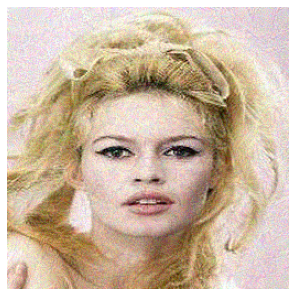

In [ ]:
fb.plot.images(clipped_advs_array3[0], scale=4.)

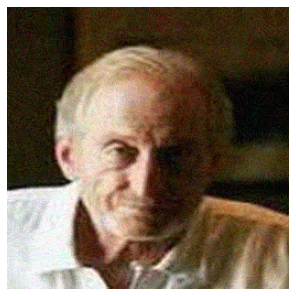

In [ ]:
fb.plot.images(clipped_advs_array2[1], scale=4.)

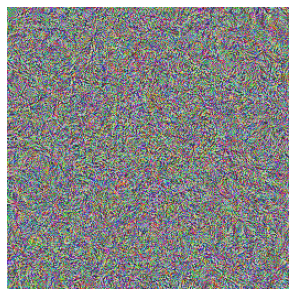

In [ ]:
fb.plot.images(clipped_advs_array2[0] - images[220], n=4, bounds=(-0.1, 0.1), scale=4.)

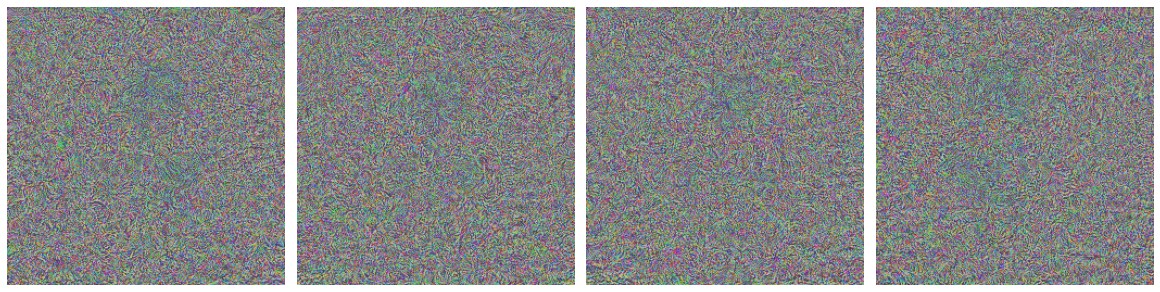

In [ ]:
fb.plot.images(clipped_advs[9] - images, n=4, bounds=(-0.1, 0.1), scale=4.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


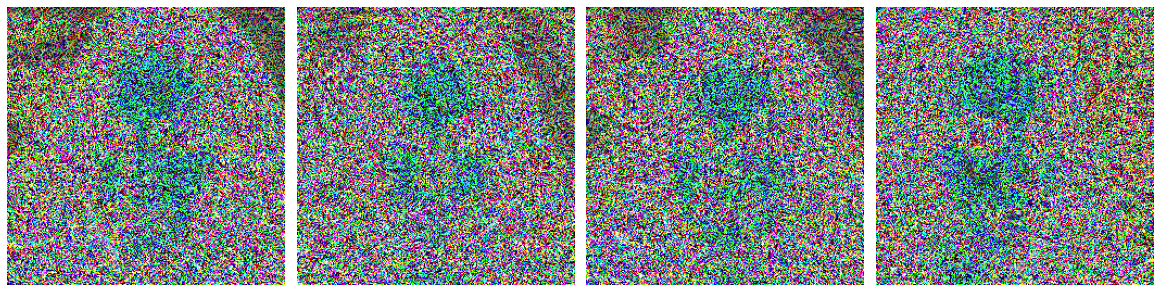

In [ ]:
fb.plot.images(clipped_advs[12] - images, n=4, bounds=(-0.1, 0.1), scale=4.)